Homework Group A
## Osama Al Kamel / Mtr Num: 3141575
## Joshua Oldridge / Mtr Num: 3140770
---

# Object Detection Mini Project
---


In [1]:
import json
import os
import random
import time
from PIL import Image, ImageDraw, ImageFont
import xml.etree.ElementTree as ET
from math import sqrt
from itertools import product as product
from tqdm import tqdm
from pprint import PrettyPrinter

import torch
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as FT
from torch.utils.data import Dataset

from matplotlib import pyplot as plt # for plotting the colors
import numpy as np

# make sure the pretrained model is saved to models directory
os.environ['TORCH_HOME'] = 'models'

# the utils we will use (see utils.py - with minor modifications of the GitHub version)
from Osama_Josh_utils import *

import warnings
warnings.filterwarnings('ignore')
# if you think that you might benefit from seeing warnings at least once do this instead:
#warnings.filterwarnings(action='once')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

As always, if possible use a GPU:

<div style="color:lightblue"> Task 1.1 we also print the device name

In [2]:
USE_ONLY_CPU = False
if USE_ONLY_CPU:
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}, Name: {torch.cuda.get_device_name(0)}') #Task 1.1

Using cuda, Name: NVIDIA GeForce RTX 3080 Laptop GPU


<div style="color:lightblue"> Task 1.2, we ensure reproducibility by defining the seed to be the same

In [3]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# Label map
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
              'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 
              'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

# Color map for bounding boxes of detected objects from 
# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', 
                   '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', 
                   '#aa6e28', '#fffac8', '#800000', '#aaffc3', 
                   '#808000', '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

## <div style="color:lightblue"> Task 1.4 <br>
- visualize colors 

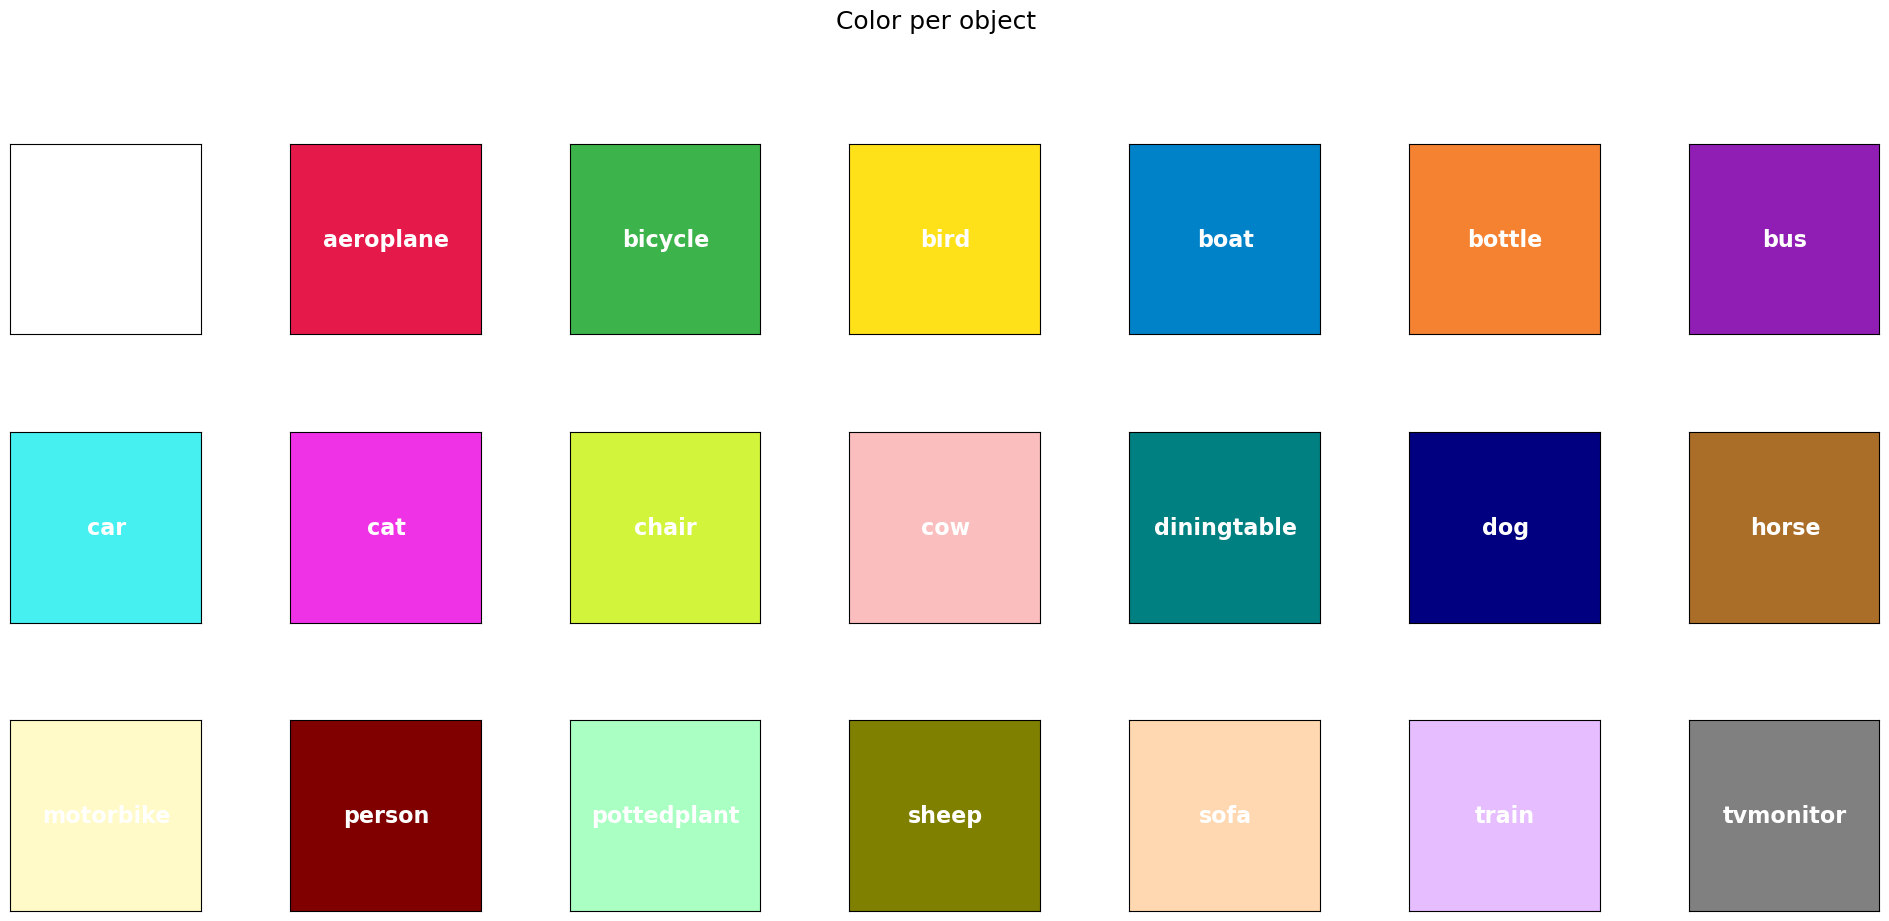

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to convert hex color to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

numofcols = 7
fig, axs = plt.subplots(nrows=3, ncols=numofcols)
fig.set_size_inches(20, 10)
fig.suptitle('Color per object\n', size=18)
fig.tight_layout(pad=3.0)

# Plot each class with its color
for idx, label in rev_label_map.items():
    img = np.zeros([100, 100, 3], dtype=np.uint8)
    color = hex_to_rgb(label_color_map[label])
    img[:, :, :] = color
    i = idx // numofcols
    j = idx % numofcols
    axs[i, j].imshow(img)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].text(50, 50, f'{label}', color='white', fontsize=16, ha='center', va='center', fontweight='bold')

plt.show()


<div style="color:lightblue"> As we can see, for some of the colors, the font color white does not fit, so we can define a map with each appropriate font color for each object color

In [6]:
text_color_map = {'background':'black','aeroplane':'white', 'bicycle':'white', 'bird':'black', 'boat':'white', 'bottle':'white', 'bus':'white', 
              'car':'black', 'cat':'black', 'chair':'black', 'cow':'black', 'diningtable':'white', 'dog':'white', 'horse':'white', 
              'motorbike':'black', 'person':'white', 'pottedplant':'black', 'sheep':'white', 'sofa':'black', 'train':'black', 'tvmonitor':'white'
              }

<div style="color:lightblue"> Then we can redraw the plot with the appropriate colors

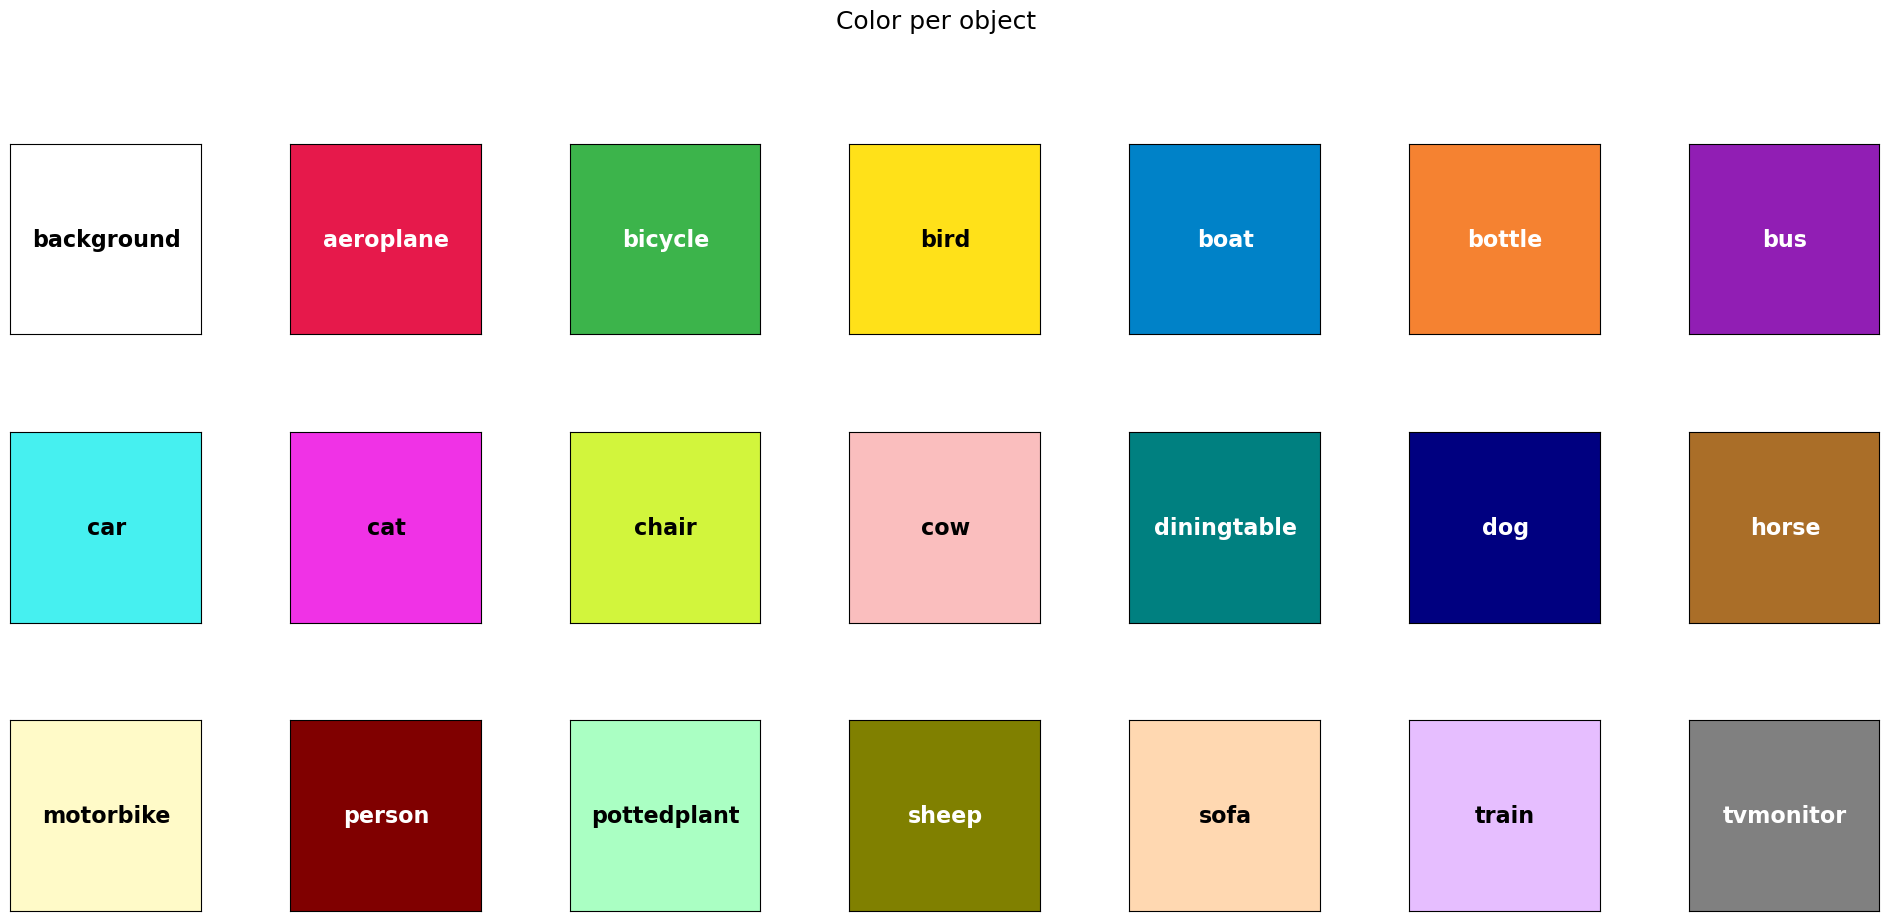

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to convert hex color to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

numofcols = 7
fig, axs = plt.subplots(nrows=3, ncols=numofcols)
fig.set_size_inches(20, 10)
fig.suptitle('Color per object\n', size=18)
fig.tight_layout(pad=3.0)

# Plot each class with its color
for idx, label in rev_label_map.items():
    img = np.zeros([100, 100, 3], dtype=np.uint8)
    color = hex_to_rgb(label_color_map[label])
    img[:, :, :] = color
    i = idx // numofcols
    j = idx % numofcols
    axs[i, j].imshow(img)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].text(50, 50, f'{label}', color=text_color_map[label], fontsize=16, ha='center', va='center', fontweight='bold')

plt.show()


In [8]:
class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if desired
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations (from utils)
        image, boxes, labels, difficulties = transform(
           image, boxes, labels, difficulties, split=self.split)
        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def image_path(self, i):
        return self.images[i]
    
    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function 
        (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, 
        and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each


<div style="color:lightblue">I have reduced the size of the train and test set so that the model can run much faster as it takes way too long to train on the whole dataset, this is to get results quick and be able to see atleast some progress

In [9]:
# Data parameters
data_folder = './data/VOC'  # folder with data files
train_batch_size = 16  # batch size for training

test_batch_size = 32  # batch size for testing
keep_difficult = True  # use objects considered difficult to detect?
workers = 0  # number of workers for loading data in the DataLoader

# Had to change the workers number to 0, as it turns out the multiprocessing does not work in the notebook
# https://github.com/pytorch/pytorch/issues/25302

# Custom dataloaders
all_dataset = PascalVOCDataset(data_folder,
                                 split='train',
                                 keep_difficult=keep_difficult)



#Reduce size for faster training

small_all_dataset, _ = torch.utils.data.random_split(all_dataset, 
                                                       [0.1, 0.9])

train_dataset, val_set = torch.utils.data.random_split(small_all_dataset, 
                                                       [0.75, 0.25])


# note that we're passing the collate function here
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,
                                           collate_fn=all_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)

val_loader =   torch.utils.data.DataLoader(val_set, batch_size=train_batch_size, shuffle=True,
                                           collate_fn=all_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)

test_dataset = PascalVOCDataset(data_folder,
                                 split='test',
                                 keep_difficult=keep_difficult)

small_test_dataset, _ = torch.utils.data.random_split(test_dataset, 
                                                       [0.05, 0.95])

# note that we're passing the collate function here
test_loader = torch.utils.data.DataLoader(small_test_dataset, batch_size=test_batch_size, shuffle=False,
                                           collate_fn=test_dataset.collate_fn, num_workers=workers)

print(f'For training, we have {len(train_dataset)} images which will be provided in {len(train_loader)} batches for one epoch')
print(f'For validation, we have {len(val_set)} images which will be provided in {len(val_loader)} batches for one epoch')
print(f'For testing, we have {len(small_test_dataset)} images which will be provided in {len(test_loader)} batches for evaluation')

For training, we have 1604 images which will be provided in 101 batches for one epoch
For validation, we have 534 images which will be provided in 34 batches for one epoch
For testing, we have 248 images which will be provided in 8 batches for evaluation


In [10]:
class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        As in the paper, we use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. See 'decimate' in utils.py.
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(weights='DEFAULT').state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")


In [11]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary/additional convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):
        """
        Forward propagation.

        :param conv7_feats: lower-level conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

In [12]:
class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.

    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 prior (default) boxes.
    See 'cxcy_to_gcxgcy' in utils.py for the encoding definition.

    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        # 4 prior-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.

        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores

In [13]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base VGG network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base(image)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = \
            self.aux_convs(conv7_feats)  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,
                                               conv11_2_feats)  # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores

    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.

        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4); this line has no effect; see Remarks section in tutorial

        return prior_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.

        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                mask = suppress < 1
                image_boxes.append(class_decoded_locs[mask])
                image_scores.append(class_scores[mask])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

In [14]:
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.

    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()  # *smooth* L1 loss in the paper; see Remarks section in the tutorial
#        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss

In [15]:
#made with help from team eugen
def validate_model(val_loader, model):
    model.eval()
    det_boxes = []
    det_labels = []
    det_scores = []
    true_boxes = []
    true_labels = []
    true_difficulties = []

    with torch.no_grad():
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(val_loader, desc='Validating...')):
            images = images.to(device)
            predicted_locs, predicted_scores = model(images)

            # Decode predicted boxes and scores
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores, min_score=0.01, max_overlap=0.45, top_k=200)

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            # Store this batch's results for mAP calculation
            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

    # Calculate mAP
    _, mAP = calculate_mAP(device, label_map, rev_label_map, det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

    model.train()  # Set model back to training mode
    return mAP

<div style="color:lightblue">
Testing: Added early stop for epochs for easy testing <br>
Task 1.5: Added save_freq and made an if case to test when to save, also saves on the lase epoch <br>
Task 2.1: Added Dict train_losses to store the loss for each corresponding epoch <br>
Task 2.2: added stopping based on history of loss, added saving best checkpoint only, added calculating mAP whenever a checkpoint is saved<br>
I also looked into early stoping with mAP, but saw online that it might be better to use loss instead of accuracy for early stopping

In [16]:
def train_for_epochs():
    """
    Training.
    """
    global start_epoch, label_map, epoch, epochs, checkpoint, decay_lr_at, batch_size, model_path
    
    #Task 1.5
    global save_freq
    
    #For testing
    global early_stop_batch
    
    #Task 2.1
    global train_losses
    
    #Task 2.2
    global early_stopping, save_best_checkpoint
    global loss_diff, threshold_for_num_of_cons_loss_below_diff
    num_of_cons = 0
    global mAP_score
    global validate_and_save_mAP
    
    
    
    # Initialize model or load checkpoint
    if checkpoint is None:
        start_epoch = 1
        model = SSD300(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        
        #Using a map to store losses to keep track of which epoch has which loss incase of not storing loss from epoch 1
        train_losses = {}
        
        #Storing mAP in a map
        mAP_score = {}
        
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)

    else:
        checkpoint = torch.load(checkpoint)
        last_epoch = checkpoint['epoch']
        start_epoch = last_epoch + 1
        print('\nLoaded checkpoint from epoch %d.\n' % last_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']
        
        #Task 2.1: try block because earlier checkpoints dont have train_losses stored
        try:
            train_losses = checkpoint['train_losses']
        except:
            train_losses = {}
            
        try:
            mAP_score = checkpoint['mAP_score']
        except:
            mAP_score = {}
            
        if mAP_score == None:
            mAP_score = {}

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
    # Epochs
    for epoch in range(start_epoch, epochs+1):
        # Decay learning rate at particular epochs
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)
        # One epoch's training
        epoch_start = time.time()
        loss = train(train_loader=train_loader,
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    epoch=epoch)
        epoch_end = time.time()
        
        #Task 2.1
        train_losses[epoch] = loss
        
        
        #added this just for testing
        if early_stop_batch is None or early_stop_batch == 0:
            print(f'Epoch {epoch} took {epoch_end - epoch_start} s')
        else:
            print(f'(for testing only) Partial Epoch {epoch} trained for {early_stop_batch} batches took {epoch_end - epoch_start} s')
        # Save checkpoint
        
        #Task 2.2: Stopping early if the change in loss is below a threshhold for n epochs
        #only test for diffrence if not set to zero
        if threshold_for_num_of_cons_loss_below_diff != 0:
           
            # Make sure we have done atleast 2 epochs before testing for loss diff, only when no history is provided
            if epoch - start_epoch >= 1 or len(train_losses) > 1:
                if train_losses[epoch-1] - train_losses[epoch] < loss_diff:
                    num_of_cons = num_of_cons + 1
                else:
                    num_of_cons = 0
            
            if save_best_checkpoint:
                if best_loss > loss:
                    best_loss = loss
                    
                    if validate_and_save_mAP:
                        mAP_score[epoch] = validate_model(val_loader, model)
                        filename = save_checkpoint_with_epcoh(model_path, epoch, model, optimizer, train_losses, mAP_score , best=True)
                    else:
                        filename = save_checkpoint_with_epcoh(model_path, epoch, model, optimizer, train_losses , best=True)
                    
                    # os.remove(oldcheckpoint) #Uncommecnt these 2 lines to delete the old checkpoint and just keep the best one
                    # oldcheckpoint = filename
                    
                    print(f"Saved Best Checkpoint for Epoch {epoch} with loss {loss}")
                    
                continue
            
            if num_of_cons >= threshold_for_num_of_cons_loss_below_diff:
                print(f"Change in loss below threshhold of {loss_diff}")
                print(f"Saved Checkpoint for Epoch {epoch}")
                
                if validate_and_save_mAP:
                    mAP_score[epoch] = validate_model(val_loader, model)
                    save_checkpoint_with_epcoh(model_path, epoch, model, optimizer, train_losses,mAP_score)
                else:
                    save_checkpoint_with_epcoh(model_path, epoch, model, optimizer, train_losses)
                break    
        
        #Task 1.5
        if epoch % save_freq == 0 or epoch == epochs:
            print(f"Saved Checkpoint for Epoch {epoch}")
            if validate_and_save_mAP:
                mAP_score[epoch] = validate_model(val_loader, model)
                save_checkpoint_with_epcoh(model_path, epoch, model, optimizer, train_losses,mAP_score)
            else:
                save_checkpoint_with_epcoh(model_path, epoch, model, optimizer, train_losses)
            
            

    return epoch, model

def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    
    #I added a variable to define an early stop to the epoch for testing
    global early_stop_batch
    
    model.train()  # training mode enables dropout
    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss
    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)
        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        if early_stop_batch is not None and early_stop_batch != 0:
            if i > early_stop_batch:
                break
        
        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored
    
    #Task 2.1 Returning the avg loss for this epoch
    return losses.avg

<div style="color:lightblue"> Task 1.3: Added epochs to be defined directly

In [17]:
# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects

model_path = 'models'

# Learning parameters

checkpoint = None  # path to model checkpoint, None if none
#checkpoint = os.path.join(model_path ,'checkpoint_075_ssd300.pth.tar')  # path to model checkpoint, None if none

# iterations = 103000  # number of iterations to train
# decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
# its_per_epoch = len(train_loader) 

print_freq = 100  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation


#My additions


#early stop for testing, stops only at the specified number of batches so that we can test the functions added
early_stop_batch = 2

#Task 1.5
save_freq = 2

#Task 1.3
#Define epochs directly instead of through iterations
epochs = 15
decay_lr_at = [10,30]

#Task 2.2
loss_diff = 0.01
threshold_for_num_of_cons_loss_below_diff = 3 #Set to zero to disable
save_best_checkpoint = False #If this is true and the above variable != 0, then the program will only save the best checkpoint and delete all others
                                #This will be done in the models/best as not to interfier with other checkpoints
validate_and_save_mAP = True #Set to save mAP with checkpoint

#Task 2.3



print(f'will train for {epochs} epochs, decaying the learning rate at epochs {decay_lr_at}')

will train for 15 epochs, decaying the learning rate at epochs [10, 30]


Now for the actual training: I am training with no early stop for 15 epochs on a reduced data set (for speed) and with validation

Note: for saving, need to have directory models/save and models/best!

In [39]:
# carry out training
last_epoch, model = train_for_epochs()
print(f'Training was continued up to epoch {last_epoch}')


Loaded base model.

Epoch: [1][0/101]	Batch Time 1.635 (1.635)	Data Time 0.837 (0.837)	Loss 23.4893 (23.4893)	
(for testing only) Partial Epoch 1 trained for 2 batches took 5.250998258590698 s
Epoch: [2][0/101]	Batch Time 1.267 (1.267)	Data Time 0.772 (0.772)	Loss 18.1002 (18.1002)	
(for testing only) Partial Epoch 2 trained for 2 batches took 4.414998769760132 s
Saved Checkpoint for Epoch 2


Validating...:   0%|          | 0/34 [00:24<?, ?it/s]


KeyboardInterrupt: 

## Plotting the Loss per Epoch

<div style="color:lightblue"> Task 2.1: plotting the loss per epoch

In [ ]:
train_losses_list = sorted(train_losses.items())

epoch, loss = zip(*train_losses_list)

plt.plot(epoch, loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluation and vizilization

In [18]:
def prep_eval(test_loader, epoch, model):
    """
    Evaluate.

    :param test_loader: DataLoader for test data
    :param model: model
    """

    global label_map, rev_label_map, device
    # Make sure it's in eval mode
    model.eval()
    description=f'Preparing Evaluation for epoch {epoch}'

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc=description)):
            images = images.to(device)  # (N, 3, 300, 300)

            # Forward prop.
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)
            
    return det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties

We can directly conduct the evaluation with the model we trained before or start with a checkpoint.

In [ ]:
eval_checkpoint = False
if eval_checkpoint:
    checkpoint = './models/checkpoint_095_ssd300.pth.tar'
    
    # Load model checkpoint that is to be evaluated
    checkpoint = torch.load(checkpoint)
    last_epoch = checkpoint['epoch']
    print(f'\nLoaded checkpoint from epoch {last_epoch}\n')
    model = checkpoint['model']
    model = model.to(device)

det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = prep_eval(
    test_loader, last_epoch, model)

Preparing Evaluation for epoch 76: 100%|██████████| 155/155 [24:48<00:00,  9.60s/it]


**Parsed predictions are evaluated against the ground truth objects.** The evaluation metric is the _Mean Average Precision (mAP)_. If you're not familiar with this metric, [here's a great explanation](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173).

We will use `calculate_mAP()` in [`utils.py`](utils.py) for this purpose. As is the norm, we will ignore _difficult_ detections in the mAP calculation. But nevertheless, it is important to include them from the evaluation dataset because if the model does detect an object that is considered to be _difficult_, it must not be counted as a false positive.

In [ ]:
# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

with torch.no_grad():
    # Calculate mAP
    APs, mAP = calculate_mAP(device, label_map, rev_label_map, 
                             det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

# Print AP for each class
pp.pprint(APs)

print(f'\nMean Average Precision (mAP) after {last_epoch} epochs: {mAP:.3f}')

Starting preparations at 2024-06-20 13:04:37.401010
Starting calculations for class 1 (i.e. aeroplane) at 2024-06-20 13:04:37.565072
Starting calculations for class 2 (i.e. bicycle) at 2024-06-20 13:04:50.802082
Starting calculations for class 3 (i.e. bird) at 2024-06-20 13:04:58.495846
Starting calculations for class 4 (i.e. boat) at 2024-06-20 13:05:31.375616
Starting calculations for class 5 (i.e. bottle) at 2024-06-20 13:06:02.726642
Starting calculations for class 6 (i.e. bus) at 2024-06-20 13:06:23.848038
Starting calculations for class 7 (i.e. car) at 2024-06-20 13:06:28.469877
Starting calculations for class 8 (i.e. cat) at 2024-06-20 13:07:27.253819
Starting calculations for class 9 (i.e. chair) at 2024-06-20 13:07:32.677820
Starting calculations for class 10 (i.e. cow) at 2024-06-20 13:09:19.050644
Starting calculations for class 11 (i.e. diningtable) at 2024-06-20 13:09:26.075251
Starting calculations for class 12 (i.e. dog) at 2024-06-20 13:09:31.421251
Starting calculation

So, after 77 epochs we obtain a mean average precision of *74.4* (your mileage might vary ...), which is already close to what the original author of the tutorial got after 232 epochs. The model he trained is reported to have scored **77.2 mAP**, same as the result reported in the paper.

Class-wise average precisions in his case (not scaled to 100) are listed below.

| Class | Average Precision |
| :-----: | :------: |
| _aeroplane_ | 0.7887580990791321 |
| _bicycle_ | 0.8351995348930359 |
| _bird_ | 0.7623348236083984 |
| _boat_ | 0.7218425273895264 |
| _bottle_ | 0.45978495478630066 |
| _bus_ | 0.8705356121063232 |
| _car_ | 0.8655831217765808 |
| _cat_ | 0.8828985095024109 |
| _chair_ | 0.5917483568191528 |
| _cow_ | 0.8255912661552429 |
| _diningtable_ | 0.756867527961731 |
| _dog_ | 0.856262743473053 |
| _horse_ | 0.8778411149978638 |
| _motorbike_ | 0.8316892385482788 |
| _person_ | 0.7884440422058105 |
| _pottedplant_ | 0.5071538090705872 |
| _sheep_ | 0.7936667799949646 |
| _sofa_ | 0.7998116612434387 |
| _train_ | 0.8655905723571777 |
| _tvmonitor_ | 0.7492395043373108 |

You can see that some objects, like bottles and potted plants, are considerably harder to detect than others (buth from his stats as well as from our own above).

Once we are satisfied with the performance of a model (or for documentation purposes), we can apply the model to as yet unseen data, i.e. use it for *inference*.

In [21]:
inf_checkpoint = False
if inf_checkpoint:
    checkpoint = 'models\checkpoint_095_ssd300.pth.tar'
    
    # Load model checkpoint that is to be evaluated
    checkpoint = torch.load(checkpoint)
    last_epoch = checkpoint['epoch']
    print(f'\nLoaded checkpoint from epoch {last_epoch}\n')
    model = checkpoint['model']
    model = model.to(device)

# Switch to eval mode
model.eval()


Loaded checkpoint from epoch 95



SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [19]:
def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transforms
    resize = transforms.Resize((300, 300))
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
#        text_size = font.getsize(det_labels[i].upper())
        text_size = []
        text_box = font.getbbox(det_labels[i].upper())
        text_size.append(text_box[2] - text_box[0])
        text_size.append(text_box[3] - text_box[1])        
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        #Task 1.3, changed the font color to be specific for each class
        draw.text(xy=text_location, text=det_labels[i].upper(), fill=text_color_map[det_labels[i]],
                  font=font)
    del draw

    return annotated_image

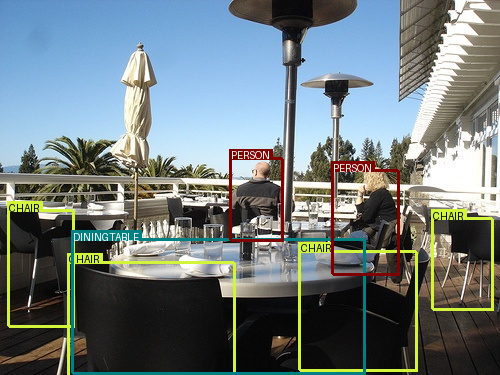

In [29]:
# sample detection
img_path = 'data/VOC/test/JPEGImages/000226.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
#detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200).show()
display(detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200))

# Draw prediction per epoch


Task 2.3: added draw ground_imgae to show detection per epoch agains the ground truth

In [23]:
def draw_ground(original_image, boxes, label):

    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    boxes = boxes * original_dims

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()

    # Suppress specific classes, if needed
    for i in range(boxes.size(0)):
        
        # Boxes
        box_location = boxes[i].tolist()
        
        draw.rectangle(xy=box_location, outline=label_color_map[rev_label_map[label[i].item()]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            rev_label_map[label[i].item()]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
            rev_label_map[label[i].item()]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
#        text_size = font.getsize(det_labels[i].upper())
        text_size = []
        text_box = font.getbbox(rev_label_map[label[i].item()].upper())
        text_size.append(text_box[2] - text_box[0])
        text_size.append(text_box[3] - text_box[1])        
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[rev_label_map[label[i].item()]])
        #Task 1.3, changed the font color to be specific for each class
        draw.text(xy=text_location, text=rev_label_map[label[i].item()].upper(), fill=text_color_map[rev_label_map[label[i].item()]],
                  font=font)
    del draw

    return annotated_image

In [60]:
def display_images_with_names(image_name_list):
    num_images = len(image_name_list)
    max_width = 3
    
    # Calculate the number of rows needed
    num_rows = (num_images + max_width - 1) // max_width
    
    # Create a figure and axes with the appropriate number of subplots
    fig, axes = plt.subplots(num_rows, max_width, figsize=(4 * max_width, 3 * num_rows))
    
    # If there's only one row, axes might not be a 2D array, so we need to make it one
    if num_rows == 1:
        axes = [axes]
    if num_images == 1:
        axes = [[axes[0]]]
    
    # Flatten the axes array for easy iteration
    axes = np.array(axes).flatten()
    
    # Loop through each image-name pair and display them
    for ax, (img, name) in zip(axes, image_name_list):
        if isinstance(img, Image.Image):
            img = img.convert("RGB")
            img = np.array(img)
        
        ax.imshow(img)
        ax.set_title(name)
        ax.axis('off')
    
    for ax in axes[num_images:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


We draw the images per epoch of the provided checkpoints and compare it to the ground truth

pottedplant
diningtable
chair
chair
chair
chair
chair
chair


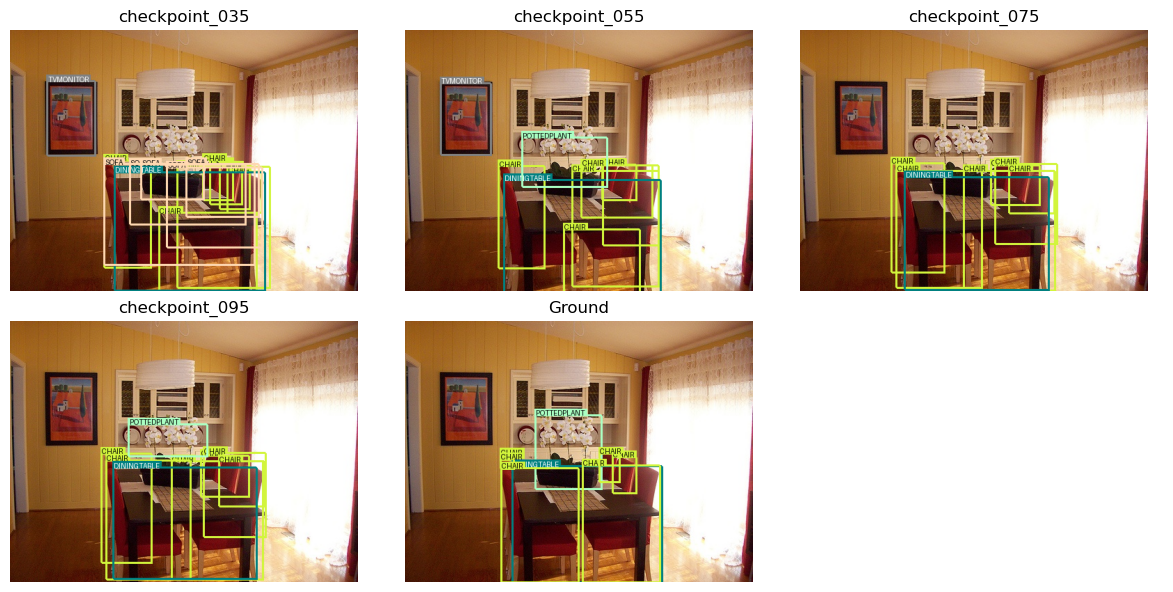

In [76]:
imgnum = 4

checkpoints_display = []
img_to_display = []
img = test_dataset.image_path(imgnum)
original_image = Image.open(img, mode='r')
original_image = original_image.convert('RGB')

for file in os.listdir("models/"):
    if file.startswith("check"):
        checkpoints_display.append(os.path.join("models/",file))

for chkpoint in checkpoints_display:
    
    original_image = Image.open(img, mode='r')
    original_image = original_image.convert('RGB')
    
    checkpoint = chkpoint
    
    # Load model checkpoint that is to be evaluated
    checkpoint = torch.load(checkpoint)
    last_epoch = checkpoint['epoch']

    model = checkpoint['model']
    model = model.to(device)
    model.eval()
    img_to_display.append((detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200), chkpoint[7:21]))
    




_, ground_boxes, ground_labels, _ = test_dataset[imgnum]


original_image = Image.open(img, mode='r')
original_image = original_image.convert('RGB')

img_to_display.append((draw_ground(original_image, ground_boxes, ground_labels), "Ground"))

display_images_with_names(img_to_display)

#display(draw_ground(original_image, ground_boxes, ground_labels))